In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
from VariationalBayes.SparseObjectives import \
    Objective, SparseObjective, pack_csr_matrix

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import autograd

import copy
from scipy import optimize

import os
import json

import time

import pickle


In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.

simulate_data = False

if not simulate_data:
    analysis_name = 'simulated_data_small'
    #analysis_name = 'simulated_data_large'
    #analysis_name = 'criteo_subsampled'

    data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                            'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')
    json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)
    y_g_vec, y_vec, x_mat, glmm_par, prior_par = logit_glmm.load_json_data(json_filename)
    
    K = x_mat.shape[1]
    NG = np.max(y_g_vec) + 1

else:
    # Generate data
    N = 200     # observations per group
    K = 5      # dimension of regressors
    NG = 200      # number of groups

    true_beta = np.array(range(5))
    true_beta = true_beta - np.mean(true_beta)
    true_mu = 0.
    true_tau = 40.0

    x_mat, y_g_vec, y_vec, true_rho, true_u = \
        logit_glmm.simulate_data(N, NG, true_beta, true_mu, true_tau)
    prior_par = logit_glmm.get_default_prior_params(K)
    glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)


print(np.mean(y_vec))

dict_keys(['y_group', 'tau_prior_alpha', 'NG', 'N', 'beta_prior_mean', 'y', 'x', 'K', 'mu_prior_info', 'tau_prior_beta', 'mu_prior_mean', 'beta_prior_info'])
0.324


In [3]:
# Initialize.

if False:
    # Slightly smarter inits would probably improve fit time, but as of now it doesn't
    # seem worth explaining in the paper.
    import pandas as pd
    #print(glmm_par)

    x_t_x = np.matmul(x_mat.transpose(), x_mat)
    x_t_y = np.matmul(x_mat.transpose(), y_vec)
    beta_init = np.linalg.solve(x_t_x, x_t_y)
    #print(beta_init)
    #plt.plot(sp.special.expit(np.matmul(x_mat, beta_init)), y_vec, 'k.')

    df = pd.DataFrame({ 'y_g': y_g_vec, 'y': y_vec}).groupby('y_g')
    #print(df.sum())
    u_init = np.array(df.sum()) / np.array(df.count()['y'])
    #plt.figure()
    print(np.min(y_g_vec))
    #plt.plot(u_init[y_g_vec], y_vec, 'k.')

glmm_par['mu'].mean.set(0.0)
glmm_par['mu'].info.set(1.0)

glmm_par['tau'].shape.set(2.0)
glmm_par['tau'].rate.set(2.0)

glmm_par['beta'].mean.set(np.full(K, 0.0))
#glmm_par['beta'].info.set(np.eye(K))
glmm_par['beta'].info.set(np.ones(K))

glmm_par['u'].mean.set(np.full(NG, 0.0))
glmm_par['u'].info.set(np.full(NG, 1.0))

free_par_vec = glmm_par.get_free()
init_par_vec = copy.deepcopy(free_par_vec)


In [4]:
# Define moment parameters
moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
get_moment_jacobian = autograd.jacobian(moment_wrapper.get_moment_vector)
moment_jac = get_moment_jacobian(init_par_vec)


In [5]:
model = logit_glmm.LogisticGLMM(glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=4)
model.get_e_log_prior()
model.get_log_lik()
model.get_entropy()

objective = Objective(model.glmm_par, model.get_kl)
objective.fun_free(free_par_vec)

# # PriorHess evaluates the second order derivative d2 EPrior / dpar dprior_par
def get_e_log_prior(prior_vec, free_par):
    model.glmm_par.set_free(free_par)
    model.prior_par.set_vector(prior_vec)
    return model.get_e_log_prior()

get_prior_model_grad = autograd.grad(get_e_log_prior, argnum=0)
get_prior_hess = autograd.jacobian(get_prior_model_grad, argnum=1)

import timeit

time_num = 10

num_draws = 3
model.set_gh_points(num_draws)
print('num_draws = ', num_draws)
print('\tFunction time:',
      timeit.timeit(lambda: objective.fun_free(free_par_vec), number=time_num) / time_num)

print('\tGrad time:', 
      timeit.timeit(lambda: objective.fun_free_grad(free_par_vec), number=time_num) / time_num)

print('\tHessian vector product time:',
      timeit.timeit(lambda: objective.fun_free_hvp(free_par_vec, free_par_vec + 1), number=time_num) / time_num)

prior_vec = model.prior_par.get_vector()
prior_hess_time = time.time()
get_prior_hess(prior_vec, init_par_vec)
prior_hess_time = time.time() - prior_hess_time
print('\tPrior hess time: ', prior_hess_time)


num_draws =  3
	Function time: 0.000844207697082311
	Grad time: 0.00681717770639807
	Hessian vector product time: 0.015149644203484058
	Prior hess time:  0.07367229461669922


In [6]:
glmm_par_opt = copy.deepcopy(glmm_par)
def tr_optimize(trust_init, num_gh_points, gtol=1e-6, maxiter=500):
    model.set_gh_points(num_gh_points)
    objective.logger.initialize()
    objective.logger.print_every = 5
    vb_opt = optimize.minimize(
        lambda par: objective.fun_free(par, verbose=True),
        x0=trust_init,
        method='trust-ncg',
        jac=objective.fun_free_grad,
        hessp=objective.fun_free_hvp,
        tol=1e-6, options={'maxiter': maxiter, 'disp': True, 'gtol': gtol })
    return vb_opt.x

def get_moment_vec(vb_opt_x):
    glmm_par_opt.set_free(vb_opt_x)
    set_moments(glmm_par_opt, moment_par)
    return moment_par.get_vector()


In [7]:
# Optimize.

print('Running Newton Trust Region.')
num_gh_points = 4
vb_time = time.time()
opt_x = tr_optimize(init_par_vec, num_gh_points, gtol=1e-6, maxiter=500)
vb_time = time.time() - vb_time

print('VB time: ', vb_time)
print('Done.')

Running Newton Trust Region.
Iter  0  value:  1034.44059918
	x_diff:  inf
Iter  5  value:  235.257298461
	x_diff:  1.33334382258
Iter  10  value:  72.6398068113
	x_diff:  1.49037294097
Iter  15  value:  69.409569197
	x_diff:  0.0684520211537
Optimization terminated successfully.
         Current function value: 69.407873
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
         Hessian evaluations: 0
VB time:  2.469855785369873
Done.


In [8]:

glmm_par.set_free(opt_x)
if simulate_data:
    print('Fit beta: ', glmm_par['beta'].e())
    print('True beta: ', true_beta)
    
    print('Fit mu: ', glmm_par['mu'].e())
    print('True mu: ', true_mu)
    
    print('Fit tau: ', glmm_par['tau'].e())
    print('True tau: ', true_tau)
    
    plt.plot(true_u, true_u, 'r.')
    plt.plot(true_u, glmm_par['u'].e(), 'k.')
    

VB time:  2.469855785369873
[ 0.72808542  1.89807706  3.30921453  4.19010817  5.24256281]
GLMM Parameters:
	mu:
mu_mean: [-3.58726387]
mu_info: [ 101.79778182]
	tau:
tau_shape: [ 53.]
tau_rate: [ 52.06911778]
	beta:
beta_mean:
[ 0.72808542  1.89807706  3.30921453  4.19010817  5.24256281]
beta_info:
[ 19.89797848  19.93550981  14.07405886  15.78453625  13.43869674]
	u:
u_mean:
[-3.07304073 -3.57646071 -3.7791838  -4.44366275 -3.51762941 -3.88706906
 -3.69985985 -3.76609831 -2.73986117 -3.47784522 -2.78587645 -3.27133411
 -3.71936898 -3.7974952  -3.59128081 -3.06523949 -3.30457884 -4.17338945
 -3.80209026 -3.03252421 -2.59012987 -3.66009584 -3.65781285 -4.55794505
 -3.2410674  -4.2917967  -3.65010274 -3.59102336 -3.26594785 -2.95183154
 -3.55973812 -3.22134048 -3.51683058 -3.91246447 -3.18961261 -5.26932803
 -3.75643143 -3.80160914 -3.99667242 -3.37721689 -3.71338164 -3.50024497
 -2.90663555 -4.46218528 -4.199366   -4.08786128 -3.04806831 -3.73155779
 -3.18446567 -3.52520178 -3.37920465 

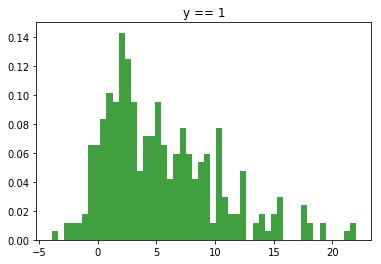

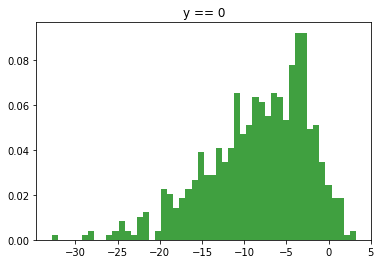

In [9]:
print('VB time: ', vb_time)

import scipy as sp

glmm_par_opt = copy.deepcopy(glmm_par)
glmm_par_opt.set_free(opt_x)
#glmm_par_opt.set_free(init_par_vec)
# print(glmm_par_opt['beta'].e())
# print(glmm_par_opt)

#plt.plot(glmm_par_opt['u'].e(), glmm_par_opt['u'].var(), 'k.')

e_beta = glmm_par_opt['beta'].e()
e_u = glmm_par_opt['u'].e()[model.y_g_vec]

z_mean = e_u + np.matmul(model.x_mat, e_beta)
#plt.plot(sp.special.expit(z_mean), model.y_vec, 'k.')

plt.figure()
plt.hist(z_mean[model.y_vec == 1], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('y == 1')

plt.figure()
plt.hist(z_mean[model.y_vec == 0], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('y == 0')




In [10]:
# # In case you want to save without calculating the Hessian, instantiate them here
if False:
    hess_time = 0.
    log_prior_hess = np.array([0.])
    elbo_hess = np.array([0.])
    moment_jac = np.array([0.])
    lrvb_cov = np.array([0.])

In [11]:
# Get the Hessians at the number of draws used for optimization
sparse_model = logit_glmm.SparseModelObjective(
    glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points, num_groups=1)
sparse_model.glmm_par.set_free(opt_x)

hess_time = time.time()
print('KL Hessian...\n')
#kl_hess = objective.fun_free_hessian(opt_x)
sparse_vector_hess = \
    sparse_model.get_sparse_vector_hessian(print_every_n=20)
elbo_hess = sparse_model.get_free_hessian(sparse_vector_hess)

print('Log prior Hessian...\n')
log_prior_hess = get_prior_hess(prior_par.get_vector(), opt_x)

moment_jac = get_moment_jacobian(opt_x)

hess_time =  time.time() - hess_time

print('hess_time: %f' % hess_time)

KL Hessian...

Calculating global hessian:
Group 1 of 0
Done.
Calculating local hessian:
Group 20 of 99
Group 40 of 99
Group 60 of 99
Group 80 of 99
Group 100 of 99
Done.
Log prior Hessian...

hess_time: 6.700524


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [12]:
sparse_model.set_group_parameters([18])

(array([  -3.58726387,  101.79778182,   53.        ,   52.06911778,
           0.72808542,    1.89807706,    3.30921453,    4.19010817,
           5.24256281,   19.89797848,   19.93550981,   14.07405886,
          15.78453625,   13.43869674,   -3.80209026,    1.26631431]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  32, 132]))

In [13]:
print('Solving systems...\n')
inverse_time = time.time()
#lrvb_cov = -1 * np.matmul(moment_jac, np.linalg.solve(elbo_hess, moment_jac.T))
elbo_inv_moment_jac = -1 * sp.sparse.linalg.spsolve(elbo_hess, moment_jac.T)
lrvb_cov = np.matmul(moment_jac, elbo_inv_moment_jac)
vb_prior_sens = np.matmul(log_prior_hess, elbo_inv_moment_jac).T
inverse_time = time.time() - inverse_time
print('Done\n')

print('Inverse time:', inverse_time)

Solving systems...

Done

Inverse time: 0.01091623306274414


In [14]:
# Sanity check
#full_elbo_hess = objective.fun_free_hessian(opt_x)
sparse_model.glmm_par.set_free(opt_x)
full_vec_elbo_hess = objective.fun_vector_hessian(sparse_model.glmm_par.get_vector())

In [15]:
# Test the sparse objectives.
sparse_model.glmm_par.set_free(opt_x)

sparse_model.set_global_parameters()
sparse_kl = -1 * sparse_model.get_global_elbo()
for g in range(NG):
    sparse_model.set_group_parameters([g])
    group_elbo = sparse_model.get_group_elbo([g])
    sparse_kl -= group_elbo
    
print(sparse_kl)
print(objective.fun_free(opt_x))
print(sparse_kl - objective.fun_free(opt_x))

[ 69.40787307]
69.4078730719
[ -5.68434189e-14]


7.1054273576e-15


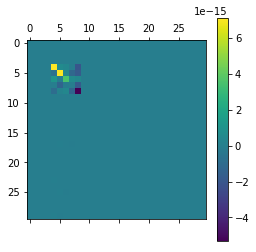

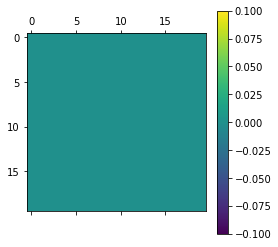

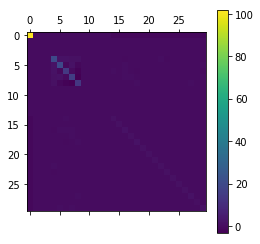

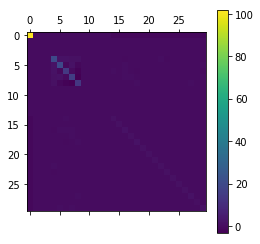

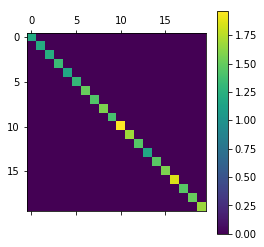

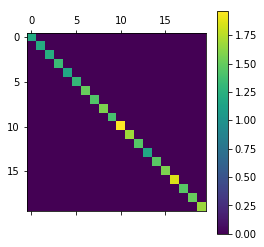

In [19]:
# print(np.max(np.abs(full_elbo_hess - elbo_hess)))
# plt.plot(full_elbo_hess.flatten(), np.squeeze(elbo_hess.todense().flatten()).T, 'k.')

print(np.max(np.abs(full_vec_elbo_hess + sparse_vector_hess)))
#plt.plot(full_vec_elbo_hess.flatten(), np.squeeze(sparse_vector_hess.todense().flatten()).T, 'k.')

# plt.matshow(sparse_vector_hess.todense()); plt.colorbar()
# plt.matshow(full_vec_elbo_hess); plt.colorbar()
plt.matshow((full_vec_elbo_hess + sparse_vector_hess.todense())[0:30, 0:30]); plt.colorbar()
plt.matshow((full_vec_elbo_hess + sparse_vector_hess.todense())[50:70, 50:70]); plt.colorbar()

plt.matshow(-1 * sparse_vector_hess.todense()[0:30, 0:30]); plt.colorbar()
plt.matshow(full_vec_elbo_hess[0:30, 0:30]); plt.colorbar()

plt.matshow(-1 * sparse_vector_hess.todense()[50:70, 50:70]); plt.colorbar()
plt.matshow(full_vec_elbo_hess[50:70, 50:70]); plt.colorbar()

In [18]:
if not simulate_data:
    # Write the result to a JSON file for use in R.
    
    run_name = 'production'
    
    pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)
    pickle_output = open(pickle_output_filename, 'wb')

    # Unlike with JSON, numpy arrays can be pickled.
    pickle_result_dict = {  'glmm_par_dictval': glmm_par_opt.dictval(),
                            'glmm_par_vector': glmm_par_opt.get_vector(),
                            'glmm_par_free': glmm_par_opt.get_free(),
                            'run_name': run_name,
                            'vb_time': vb_time,
                            'hess_time': hess_time,
                            'inverse_time': inverse_time,
                            'num_gh_points': num_gh_points, 
                            'lrvb_cov': np.squeeze(lrvb_cov),
                            'moment_jac': np.squeeze(moment_jac),
                            'elbo_hess_packed': pack_csr_matrix(elbo_hess),
                            'vb_prior_sens': np.squeeze(vb_prior_sens),
                            'log_prior_hess': np.squeeze(log_prior_hess) }

    # Pickle dictionary using protocol 0.
    pickle.dump(pickle_result_dict, pickle_output)
    pickle_output.close()
    
    print(pickle_output_filename)


print('\n\nDONE.')
    

/home/rgiordan/Documents/git_repos/LinearResponseVariationalBayes.py/Models/LogisticGLMM/data/simulated_data_small_python_vb_results.pkl


DONE.
